<a href="https://colab.research.google.com/github/BlackeWhite/SSD_Modanet/blob/master/SSD300/SSD300_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load File and library

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#pesi 
Weight = drive.CreateFile({'id': '1Ldszh6MHnGyQRrmZGn4-gln1SgQPGZ1v'}) 
Weight.GetContentFile(Weight['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(Weight['title'], Weight['id']))
#dataset
Modadat = drive.CreateFile({'id': '1il_eW1COHs1_QijMh3zklvhmE_Dfk0qh'}) 
Modadat.GetContentFile(Modadat['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(Modadat['title'], Modadat['id']))
!unzip dataset.zip
#annotazioni
annotaz = drive.CreateFile({'id': '1aD4BgDD7grEFYlDKr0k_SHPw1qbt9N1q'}) 
annotaz.GetContentFile(annotaz['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(annotaz['title'], annotaz['id']))
!unzip annotazioni.zip

!pip install keras==2.2.3
!pip install tensorflow-gpu==1.15


import h5py
import numpy as np
import shutil
import os.path
if not(os.path.isdir('keras_layers')):
  !git clone https://github.com/pierluigiferrari/ssd_keras.git
  !mv ./ssd_keras/* . #copy all file in the root directory, you must this because after invocate the lib in the repository 
  !rm -r ssd_keras


In [ ]:
import h5py
import numpy as np
import shutil
import os.path
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam,SGD
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.


In [ ]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR
n_classes = 13
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_coco
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; 
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
model_mode = 'inference'

# Load Model

In [ ]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)


# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = '/content/ssd300_Modanet_data-aug_epoch-150_loss-5.3164_val_loss-5.1061.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss, metrics=['acc'])

# Load Test Set

In [ ]:
def rename(path):
	lis = os.listdir(path)
	for item in lis:
		temp=item.split(".")
		while len(temp[0])<7:
			new=str(0)+temp[0]
			temp[0]=new
			if len(temp[0])==7:
				os.rename(path+item,path+temp[0]+".jpg")

In [ ]:
rename('./new_test/')
rename('./new_val/')

In [ ]:

dataset = DataGenerator()

classes = ['background','bag', 'belt', 'boots', 'footwear',
           'outer', 'dress', 'sunglasses', 'pants',
           'top', 'shorts', 'skirt', 'headwear',
           'scarf/tie']


# TODO: Set the paths to the dataset here.
MS_COCO_dataset_images_dir = './new_test/'
MS_COCO_dataset_annotations_filename = './annotazioni_test.json'

dataset.parse_json(images_dirs=[MS_COCO_dataset_images_dir],
                   annotations_filenames=[MS_COCO_dataset_annotations_filename],
                   ground_truth_available=True,
                   include_classes='all',
                   ret=False)

Processing 'annotazioni_test.json': 100%|██████████| 5220/5220 [00:00<00:00, 74024.64it/s]


# Evaluation

In [ ]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode='inference')

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=1,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    decoding_iou_threshold=0.45,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 5220

Producing predictions batch-wise: 100%|██████████| 5220/5220 [07:27<00:00, 11.67it/s]
Matching predictions to ground truth, class 1/13.: 100%|██████████| 70859/70859 [00:03<00:00, 18210.47it/s]
Matching predictions to ground truth, class 2/13.: 100%|██████████| 45573/45573 [00:02<00:00, 20160.83it/s]
Matching predictions to ground truth, class 3/13.: 100%|██████████| 20787/20787 [00:01<00:00, 12190.11it/s]
Matching predictions to ground truth, class 4/13.: 100%|██████████| 816462/816462 [01:21<00:00, 9976.41it/s] 
Matching predictions to ground truth, class 5/13.: 100%|██████████| 7838/7838 [00:00<00:00, 11265.85it/s]
Matching predictions to ground truth, class 6/13.: 100%|██████████| 3689/3689 [00:00<00:00, 14411.95it/s]
Matching predictions to ground truth, class 7/13.: 100%|██████████| 7990/7990 [00:00<00:00, 23718.99it/s]
Matching predictions to ground truth, class 8/13.: 100%|██████████| 7270/7270 [00:00<00:00, 12625.53it/s]
Matchi

In [ ]:
print("Average Precision SSD300 with data Augmentation")
for i in range(1, len(average_precisions)):
    print("{:<17}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<17}{:<6}{}".format('All categories','mAP', round(mean_average_precision, 3)))

Average Precision SSD300 with data Augmentation
bag              AP    0.712
belt             AP    0.361
boots            AP    0.204
footwear         AP    0.231
outer            AP    0.809
dress            AP    0.821
sunglasses       AP    0.792
pants            AP    0.889
top              AP    0.745
shorts           AP    0.795
skirt            AP    0.809
headwear         AP    0.829
scarf/tie        AP    0.443

All categories   mAP   0.649


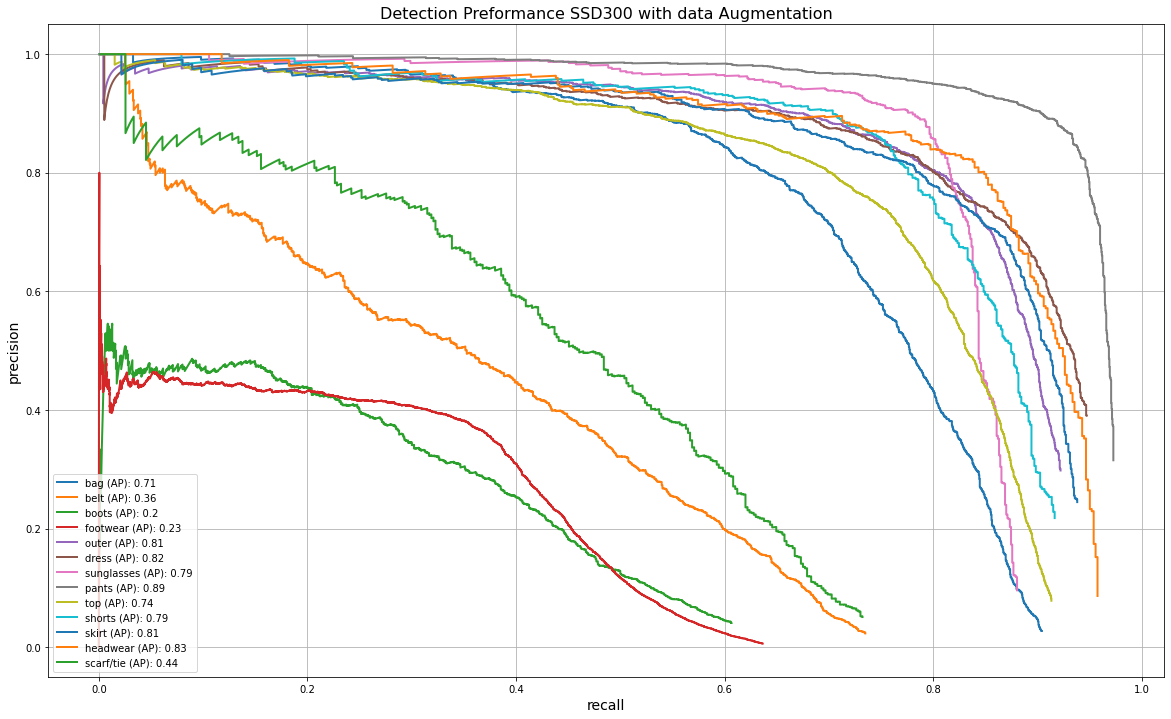

In [ ]:
m = max((n_classes+1) // 2, 2)
n = 2


plt.figure(figsize=(20,12))
plt.title("Detection Preformance SSD300 with data Augmentation", fontsize=16)


for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        plt.plot(recalls[n*i+j+1], precisions[n*i+j+1], linewidth=2.0, label=classes[n*i+j+1]+" (AP): "+ str(round(average_precisions[n*i+j+1],2)))
        plt.legend()
        plt.xlabel('recall', fontsize=14)
        plt.ylabel('precision', fontsize=14)
        plt.grid(True)